In [1]:
pip install --upgrade spacy

     |████████████████████████████████| 6.2 MB 13.4 MB/s 
     |████████████████████████████████| 457 kB 60.3 MB/s 
     |████████████████████████████████| 181 kB 67.6 MB/s 
     |████████████████████████████████| 10.1 MB 57.3 MB/s 
     |████████████████████████████████| 660 kB 59.0 MB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    

In [2]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 33.5 MB 219 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
pip install podium-nlp

     |████████████████████████████████| 124 kB 14.2 MB/s 
     |████████████████████████████████| 212 kB 40.2 MB/s 
     |████████████████████████████████| 4.0 MB 38.6 MB/s 
     |████████████████████████████████| 62 kB 538 kB/s 
     |████████████████████████████████| 856 kB 12.6 MB/s 


In [4]:
pip install bertopic

     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 88 kB 7.7 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
     |████████████████████████████████| 5.2 MB 21.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.2 MB 32.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 636 kB 33.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.2 MB/s 
     |████████████████████████████████| 1.1 MB 58.0 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342154 sha256=9a8f4ce2814314ffc666596be66b2f3b232208771054f0fd94e4928b7bac1793
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
  Created wheel for sentence-

In [5]:
pip install emoji

     |████████████████████████████████| 175 kB 26.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=bfdefd27d8e1d208463fd45c392370937e2f19284c0598e9e58bbc7062732f84
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [6]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd drive/MyDrive/datasets/

/content/drive/MyDrive/datasets


In [9]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [10]:
df_test['Tweet text'] = df_test['Tweet text'].apply(emoji.demojize)

In [11]:
def word_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith(("@", "#"))]
    return len(newlist)

def tag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("@")]
    return len(newlist)

def hashtag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("#")]
    return len(newlist)

def has_emoji(s):
    splitted = s.split()
    newlist = [x for x in splitted if x != ":" and x.startswith(":") and x.endswith(":")]
    return len(newlist)

def clean_text(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith((":", "@", "#"))]
    return ' '.join(newlist)

### dodani featuresi ###
def link_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith(('http:', 'https:'))]
    return len(newlist)

def smiley_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not re.match(r'([\:\;\=][\(\)PD]+)+', x)]
    return len(newlist)

def exclamation_mark_counter(s):
    return s.count('!')

In [12]:
df['length'] = df['Tweet text'].apply(len)
df['word_count'] = df['Tweet text'].apply(word_counter)
df['tag_count'] = df['Tweet text'].apply(tag_counter)
df['hashtag_count'] = df['Tweet text'].apply(hashtag_counter)
df['link_count'] = df['Tweet text'].apply(link_counter)
df['smiley_count'] = df['Tweet text'].apply(smiley_counter)
df['exclamation_mark_count'] = df['Tweet text'].apply(exclamation_mark_counter)
df['has_emoji'] = df['Tweet text'].apply(has_emoji)
df['clean_text'] = df['Tweet text'].apply(clean_text)

In [13]:
nlp = spacy.load("en_core_web_md") # treba instalirat ako nemate, s md cemo dobivat bolji performans a i dalje nije prevelik

In [14]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [15]:
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text
3753,3771,1,Time to free ourselves of the Tyranny of the U...,123,22,0,0,0,22,0,0,Time to free ourselves of the Tyranny of the U...
1910,1914,0,is too complex a word for him to understand @...,79,9,3,0,0,12,0,0,is too complex a word for him to understand
3791,3809,1,@BBCRadMac @StuartMaconie years ago in M && S ...,134,22,2,1,0,25,1,0,years ago in M && S in Rochdale they had 2 lef...
3774,3792,1,China calls US hypocritical on #humanrights bu...,133,19,1,1,1,21,0,0,China calls US hypocritical on but Chinese pea...
2712,2716,0,"Coin ! erraji: "" ZeeGingaNinja: because it see...",135,17,0,1,1,18,1,0,"Coin ! erraji: "" ZeeGingaNinja: because it see..."
...,...,...,...,...,...,...,...,...,...,...,...,...
765,766,0,"@jerridsebesta my mom told me not to do it, bu...",56,11,1,0,0,12,0,0,"my mom told me not to do it, but I'm fine"
212,213,1,So Aaron sorkin goes on @todayshow to talk ab...,130,22,1,0,0,23,0,0,So Aaron sorkin goes on to talk about not liki...
737,738,1,@STN_Airport your busy staff standing about w...,91,9,1,1,1,11,0,0,your busy staff standing about when people que...
2052,2056,1,!!! RT @JeremyClarkson: Of all the places to g...,94,14,1,0,1,15,3,0,!!! RT Of all the places to get stuck in a tra...


## Preprocessing for classification

In [16]:
!pip install tweet-preprocessor

In [17]:
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY)
# tweet_text_train['clean text'] = tweet_text_train['Tweet text'].map(lambda x: p.clean(x))
# tweet_text_validation['clean text'] = tweet_text_validation['Tweet text'].map(lambda x: p.clean(x))

In [18]:
# tweet_text_train.head()

In [19]:
# for i in tweet_text_train.index[0:50]:
#     print(tweet_text_train.loc[i, 'clean text'])

In [20]:
# from nltk.tokenize import TweetTokenizer

# tokenizer = TweetTokenizer()
# tweet_text_train['tokens'] = tweet_text_train['clean text'].apply(tokenizer.tokenize)
# tweet_text_validation['tokens'] = tweet_text_validation['clean text'].apply(tokenizer.tokenize)

# tweet_text_train['tokens']

In [21]:
# stop_words = nlp.Defaults.stop_words

# tweet_text_train['text wo stop'] = tweet_text_train['tokens'].apply(lambda x: [i for i in x if i not in stop_words])
# tweet_text_validation['text wo stop'] = tweet_text_validation['tokens'].apply(lambda x: [i for i in x if i not in stop_words])

# tweet_text_train['text wo stop']

## Preprocessing for topic modelling

In [22]:
tweet_text_train = df_train[['Tweet text']]
tweet_text_validation = df_validation[['Tweet text']]

tweet_text_train.head(15)

,Tweet text
3753,Time to free ourselves of the Tyranny of the U...
1910,is too complex a word for him to understand @...
3791,@BBCRadMac @StuartMaconie years ago in M && S ...
3774,China calls US hypocritical on #humanrights bu...
2712,"Coin ! erraji: "" ZeeGingaNinja: because it see..."
2344,Yay for no longer having a vehicle! :pensive_...
2233,@DlSCORD @FoxNews Hates his anti-American/anti...
171,That was the cutest thing ever :smiling_face_w...
1885,@KevinnCyrus lol of course it's the best!!
2218,work should be fun today :unamused_face:


In [23]:
def preprocess_words(s):
    '''Removes tags, emojis, links, smiley faces, hashtag signs, stopwords and changes the case to lower.'''
    ret_list = []

    smiley_regex = r'([\:\;\=][\(\)PDO\/\\\]\[]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: w != ':' and w.startswith(':') and w.endswith(':')
    remove_emoji = lambda w: w[:w.index(':')] + w[w.rindex(':')+1:] if ':' in w and w.index(':') != w.rindex(':') else w
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)
    
    for i, s_i in enumerate(s):
        w_arr = s_i.split()
        w2 = []
        for w in w_arr:
            if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
                continue
            
            elif is_hashtag(w):
                w_tmp = w.replace('#', '')
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            elif is_smiley(w):
                w_tmp = re.sub(smiley_regex, '', w)
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            else:
                if w != '':
                    w.replace('#', '')
                    w.replace('|', '')
                    w.replace('_', '')
                    lower_append(w, w2)

        ret_list.append(' '.join(w2))
    return ret_list

def lower_append(w, l):
    l.append(w.lower())

tweet_text_train = tweet_text_train.apply(preprocess_words)
tweet_text_validation = tweet_text_validation.apply(preprocess_words)
df_test = df_test[['Tweet text']].apply(preprocess_words)

In [24]:
tweet_text_train.head(15)

,Tweet text
3753,time to free ourselves of the tyranny of the u...
1910,is too complex a word for him to understand
3791,years ago in m && s in rochdale they had 2 lef...
3774,china calls us hypocritical on humanrights but...
2712,"coin ! erraji: "" zeeginganinja: because it see..."
2344,yay for no longer having a vehicle!
2233,hates his anti-american/anti-constitution poli...
171,that was the cutest thing ever
1885,lol of course it's the best!!
2218,work should be fun today


In [25]:
def simple_preprocessing(s):
    '''Lowercases, tokenizes, de-accents, removes words shorter than 3 and longer than 14 characters'''
    return [' '.join(simple_preprocess(s_i)) for s_i in s]

tweet_text_train = tweet_text_train.apply(simple_preprocessing)
tweet_text_validation = tweet_text_validation.apply(simple_preprocessing)
df_test = df_test.apply(simple_preprocessing)

In [26]:
tweet_text_train.head(15)

,Tweet text
3753,time to free ourselves of the tyranny of the u...
1910,is too complex word for him to understand
3791,years ago in in rochdale they had left shoes o...
3774,china calls us hypocritical on humanrights but...
2712,coin erraji zeeginganinja because it seems tha...
2344,yay for no longer having vehicle
2233,hates his anti american anti constitution poli...
171,that was the cutest thing ever
1885,lol of course it the best
2218,work should be fun today


In [27]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

tweet_text_train = tweet_text_train.apply(remove_tuple_characters)
tweet_text_validation = tweet_text_validation.apply(remove_tuple_characters)
df_test = df_test.apply(remove_tuple_characters)

tweet_text_train.head(15)

,Tweet text
3753,time to free ourselves of the tyranny of the u...
1910,is too complex word for him to understand
3791,years ago in in rochdale they had left shoes o...
3774,china calls us hypocritical on humanrights but...
2712,coin erraji zeeginganinja because it seems tha...
2344,yay for no longer having vehicle
2233,hates his anti american anti constitution poli...
171,that was the cutest thing ever
1885,lol of course it the best
2218,work should be fun today


In [28]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [w.lemma_.lower() for w in nlp(s) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct]

def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    tmp = [' '.join([w for w in s_i]) for s_i in s]
    return [i for i in tmp if i != '']
        
tweet_text_train = tweet_text_train['Tweet text'].apply(lemmatize)
tweet_text_validation = tweet_text_validation['Tweet text'].apply(lemmatize)
df_test = df_test['Tweet text'].apply(lemmatize)


In [29]:
tweet_text_train.head(15)

3753    [time, free, tyranny, usa, lean, tolerant, soc...
1910                          [complex, word, understand]
3791    [year, ago, rochdale, leave, shoe, sale, reduc...
3774    [china, hypocritical, humanright, chinese, pea...
2712    [coin, erraji, zeeginganinja, people, need, cl...
2344                                 [yay, long, vehicle]
2233    [hate, anti, american, anti, constitution, pol...
171                                          [cut, thing]
1885                                  [lol, course, good]
2218                                   [work, fun, today]
2258    [rush, rush, rush, pow, football, window, glas...
1145                         [isabelle, send, nice, text]
2517    [drive, ferrari, right, beautiful, clever, woman]
2960                         [good, morning, livingqwale]
1771                        [spinlessgutless, acceptable]
Name: Tweet text, dtype: object

In [30]:
tweet_text_train = join_docs(tweet_text_train)
tweet_text_validation = join_docs(tweet_text_validation)
tweet_text_test = join_docs(df_test.tolist())

In [ ]:
tweet_text_train

## Topic modeling baselines

In [32]:
vectorizer = CountVectorizer(
    analyzer='word',
    min_df=5,
    max_df=0.8,
)

vectorizer2 = TfidfVectorizer(
    analyzer='word',
    min_df=5,
    max_df=0.8,
)

tweet_text_count_train = vectorizer.fit_transform(tweet_text_train)
tweet_text_count_validation = vectorizer.transform(tweet_text_validation)

tweet_text_tfidf_train = vectorizer2.fit_transform(tweet_text_train)
tweet_text_tfidf_validation = vectorizer2.transform(tweet_text_validation)

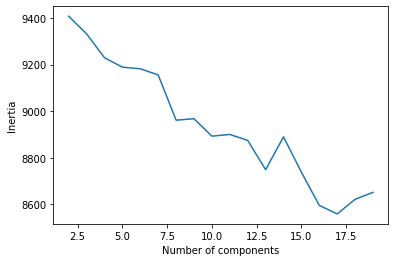

In [33]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

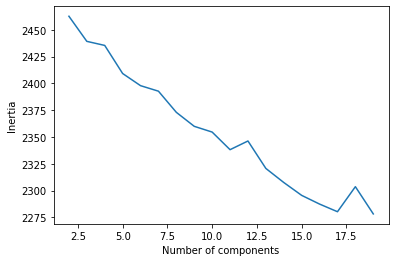

In [34]:
inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

### BERTopic

In [96]:
from bertopic import BERTopic

topic_model = BERTopic(min_topic_size=20)
topics, probs = topic_model.fit_transform(tweet_text_train)
predictions = topic_model.transform(tweet_text_test)

In [97]:
topic_model.get_topic(0)

[('game', 0.061806643983562705),
 ('rt', 0.04258301056598353),
 ('play', 0.03986741451561276),
 ('team', 0.03788437648024083),
 ('win', 0.03453450185835818),
 ('season', 0.033060096970449405),
 ('player', 0.02892758484914323),
 ('good', 0.0283964010700821),
 ('pick', 0.027129132218288953),
 ('mean', 0.026690803137999587)]

In [98]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1348,-1_like_love_day_oh
1,0,144,0_game_rt_play_team
2,1,128,1_think_funny_know_thank
3,2,114,2_sleep_wake_morning_bed
4,3,113,3_day_today_work_week
5,4,102,4_study_school_test_class
6,5,93,5_food_eat_sit_drink
7,6,85,6_christmas_gift_day_xmas
8,7,78,7_pay_service_mobile_internet
9,8,75,8_twitter_tweet_follow_follower


## LDA with TF IDF 

In [35]:
def plot_top_words(model, feature_names, n_top_words, title, i, j):
    fig, axes = plt.subplots(j, i, figsize=(20, 3*j), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}")
        ax.invert_yaxis()
        ax.tick_params(axis="both",labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

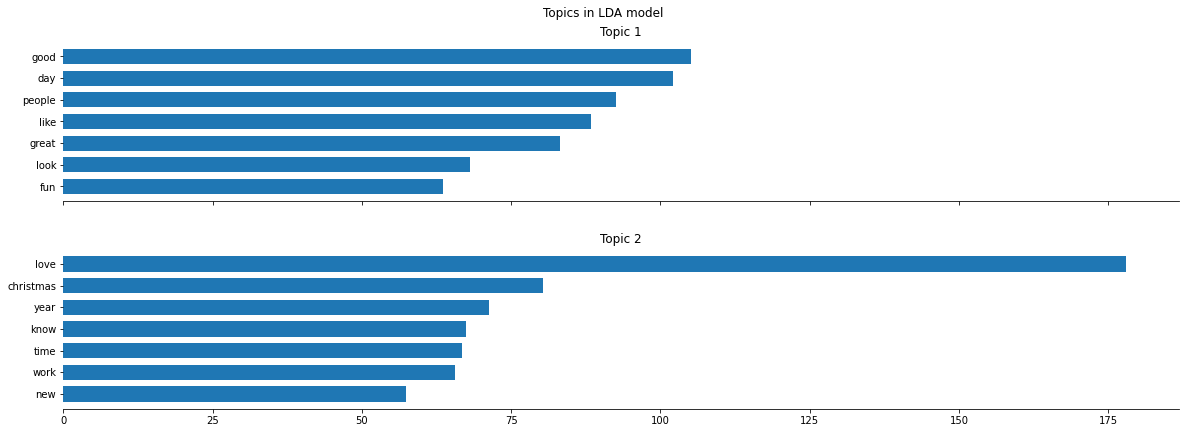

In [36]:
n_top_words = 7

def do_lda_and_plot(n_components, data):
    lda = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=5,
        learning_method="online",
        learning_offset=50.0,
    )
    lda.fit(data)

    tf_feature_names = vectorizer2.get_feature_names_out()
    plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model", 1, n_components)

do_lda_and_plot(2, tweet_text_count_train)

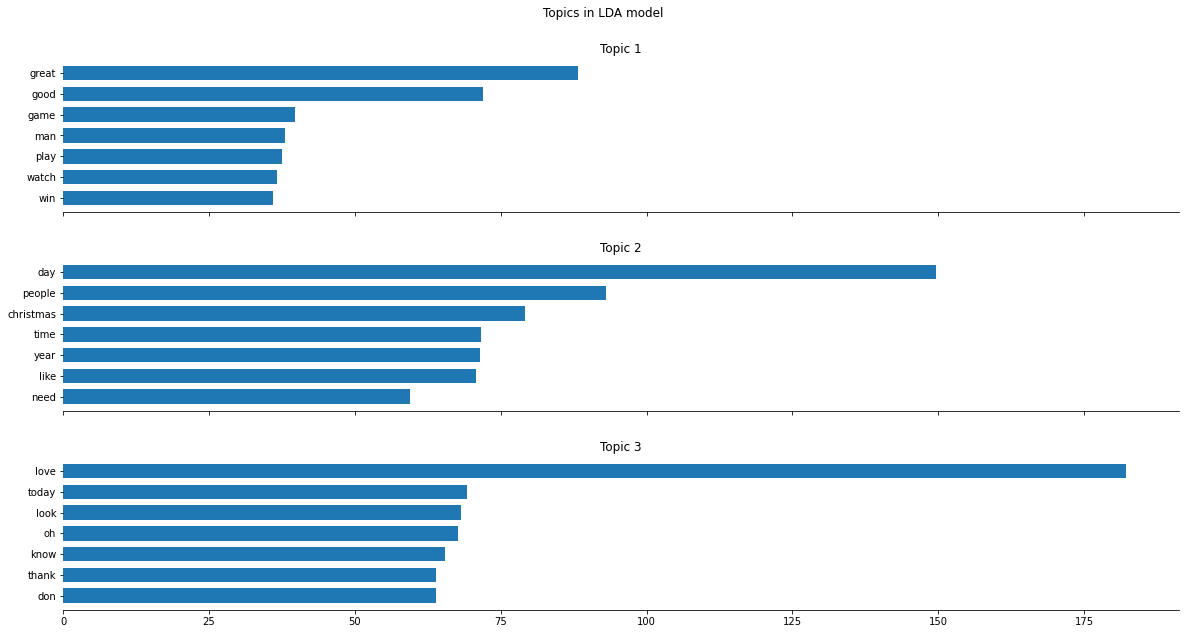

In [37]:
do_lda_and_plot(3, tweet_text_count_train)

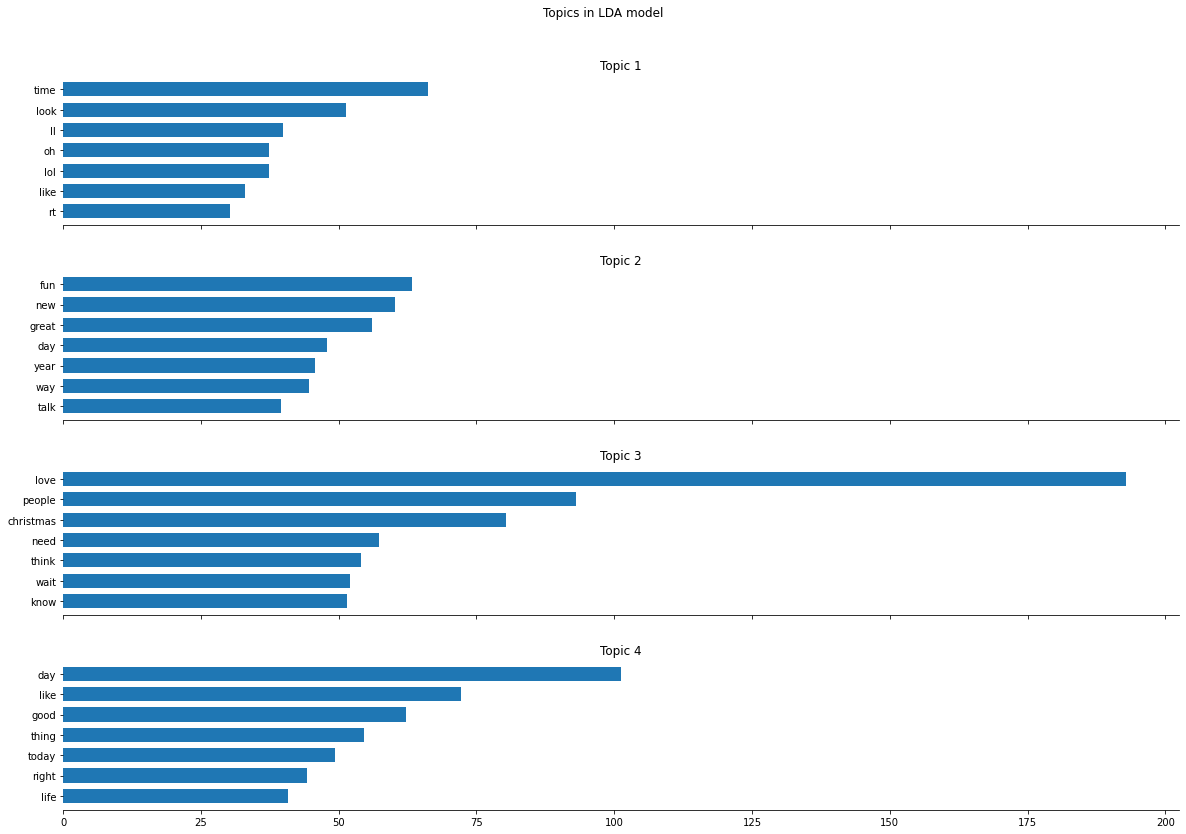

In [38]:
do_lda_and_plot(4, tweet_text_count_train)

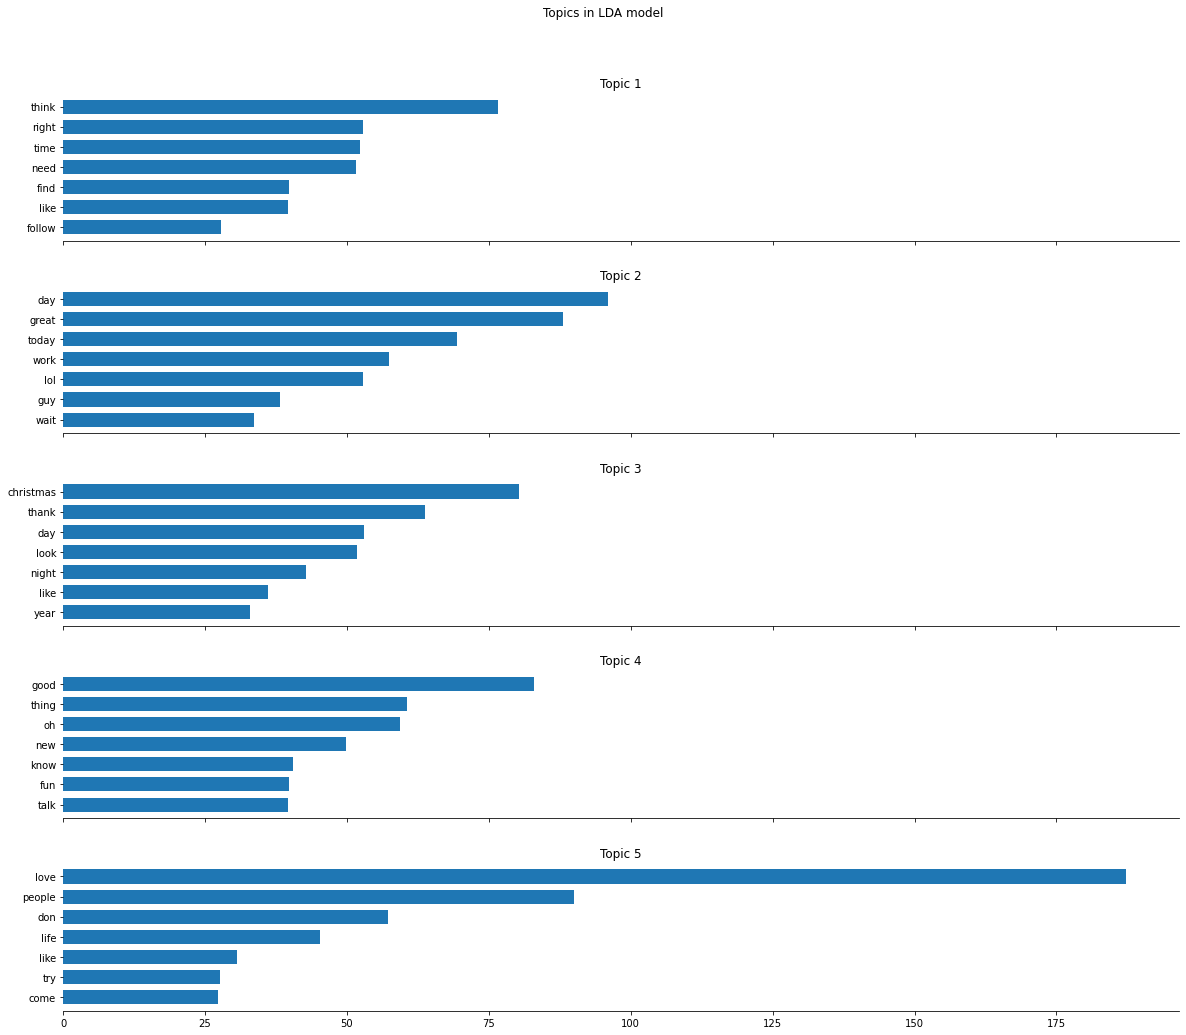

In [39]:
do_lda_and_plot(5, tweet_text_count_train)

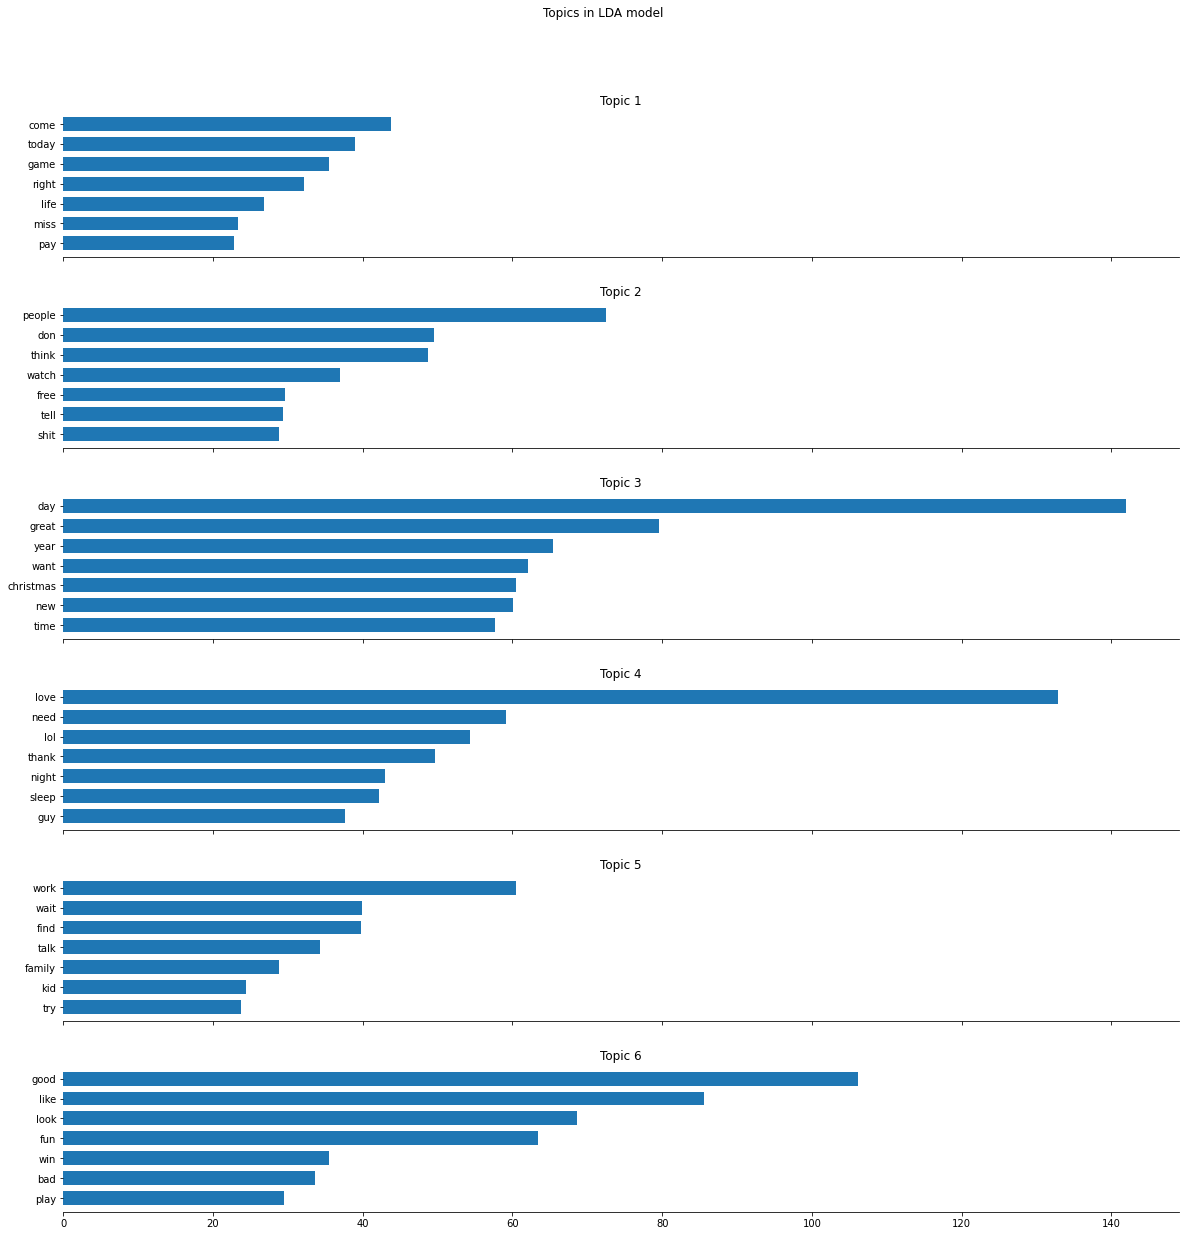

In [40]:
do_lda_and_plot(6, tweet_text_count_train)

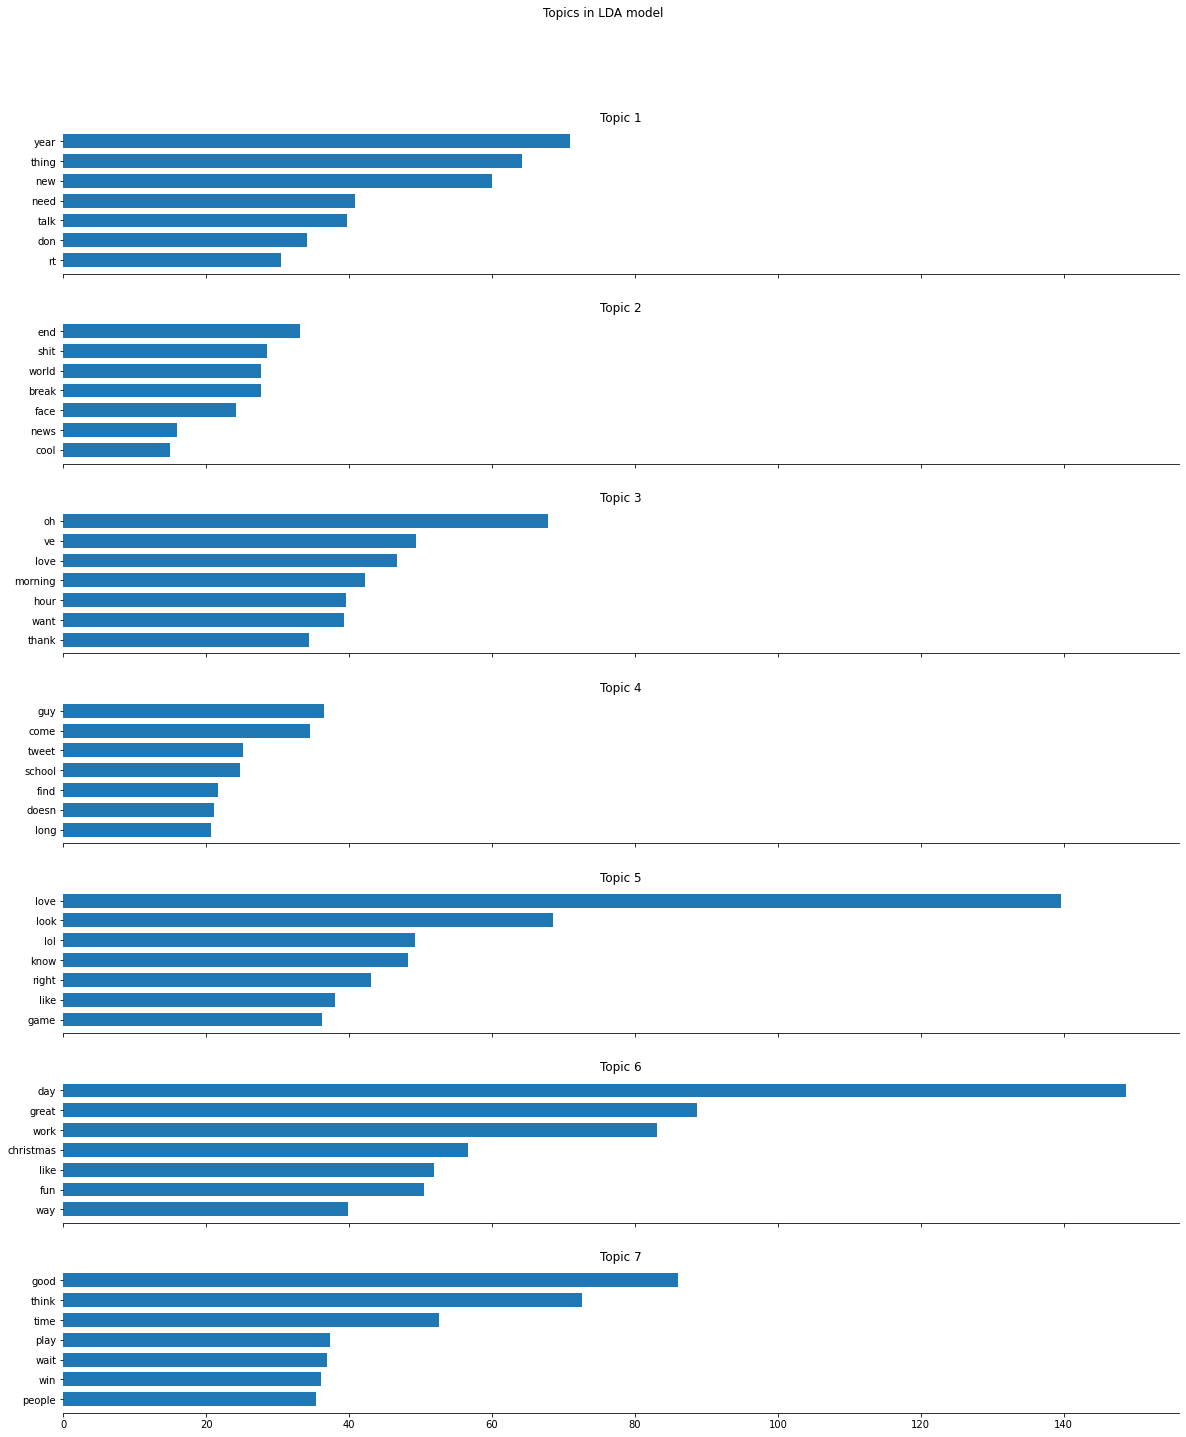

In [41]:
do_lda_and_plot(7, tweet_text_count_train)

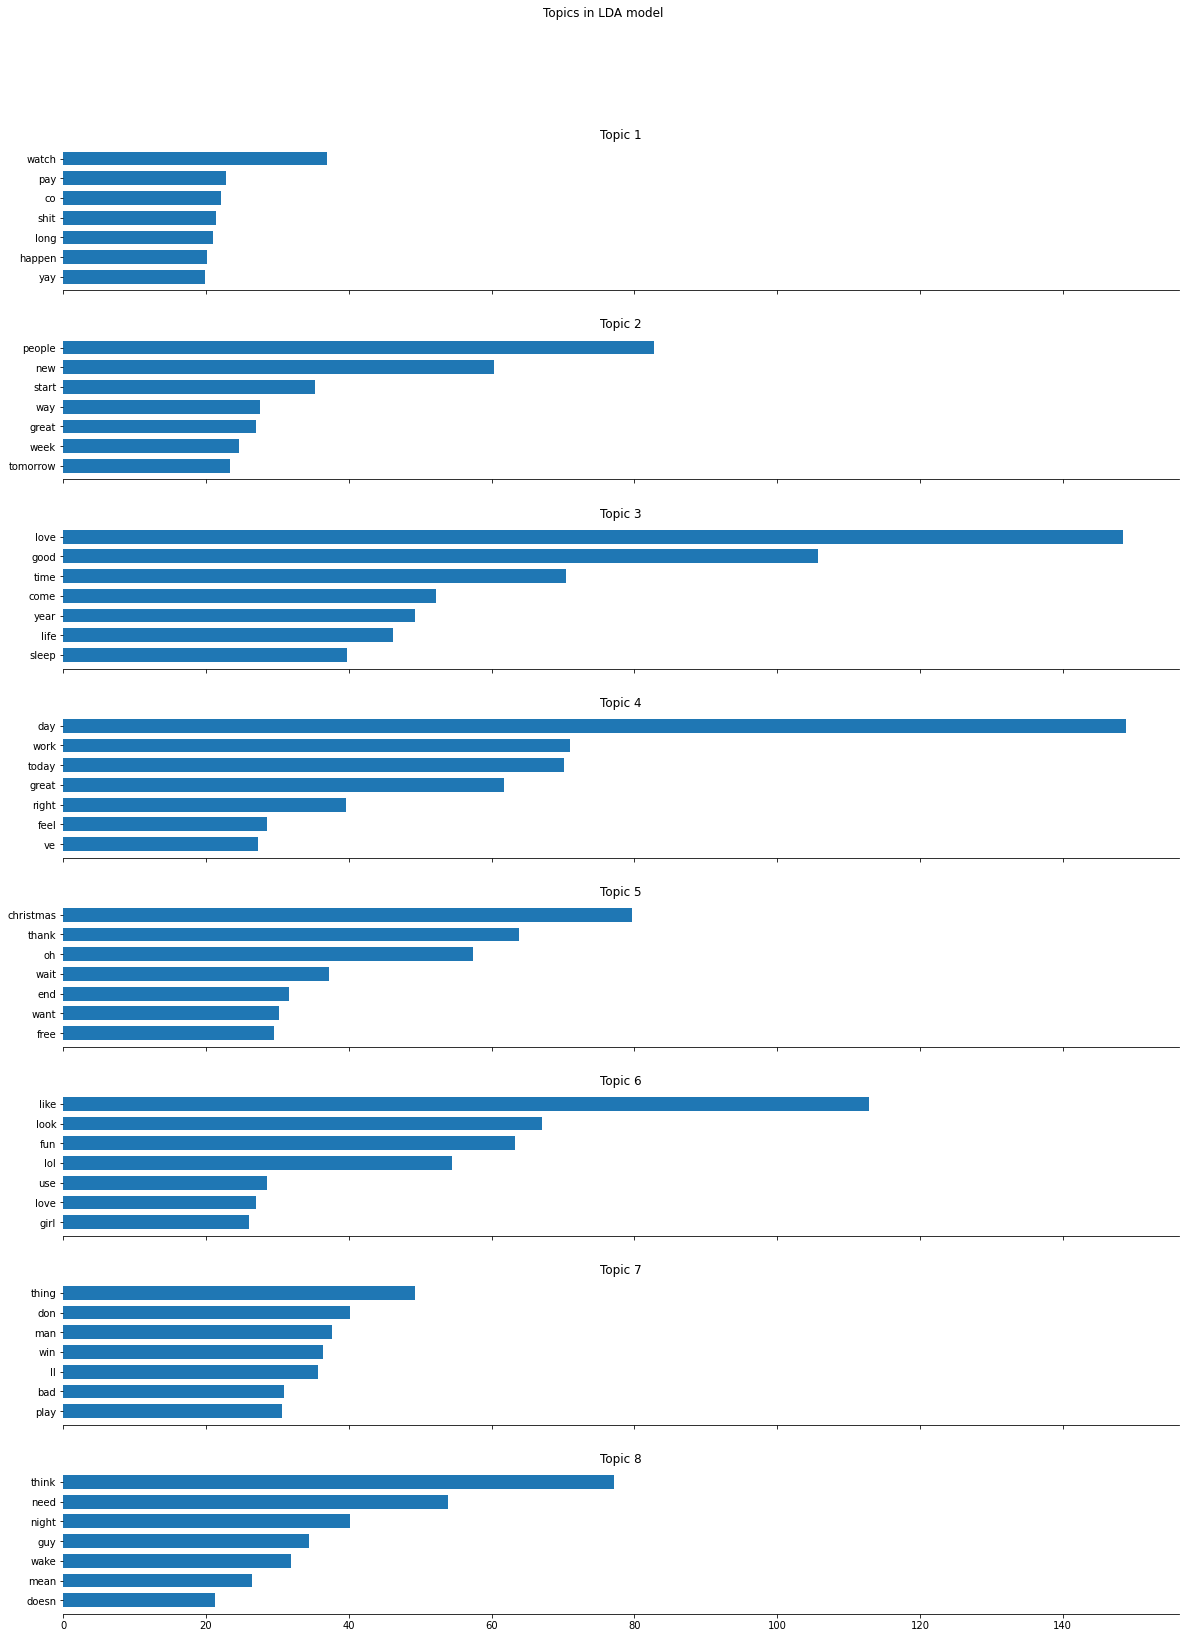

In [42]:
do_lda_and_plot(8, tweet_text_count_train)

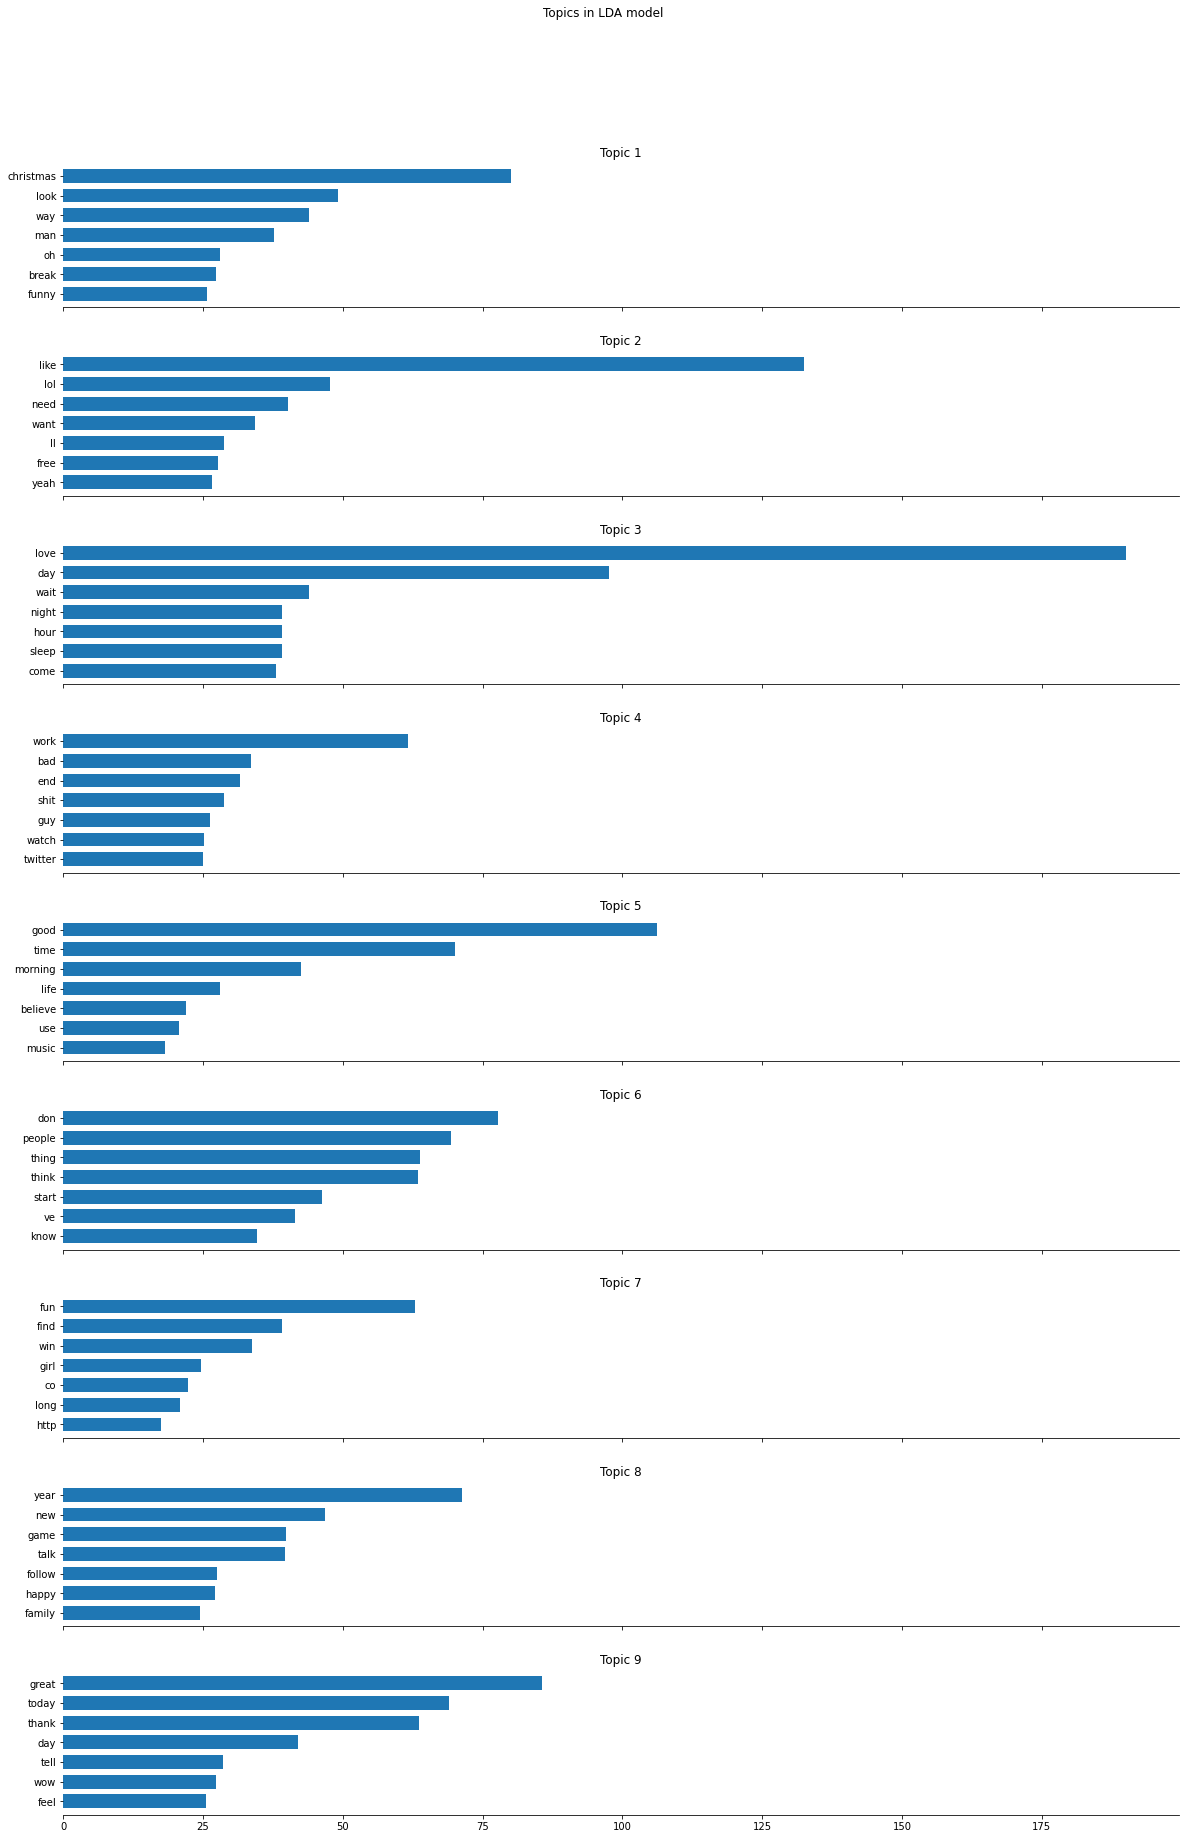

In [43]:
do_lda_and_plot(9, tweet_text_count_train)

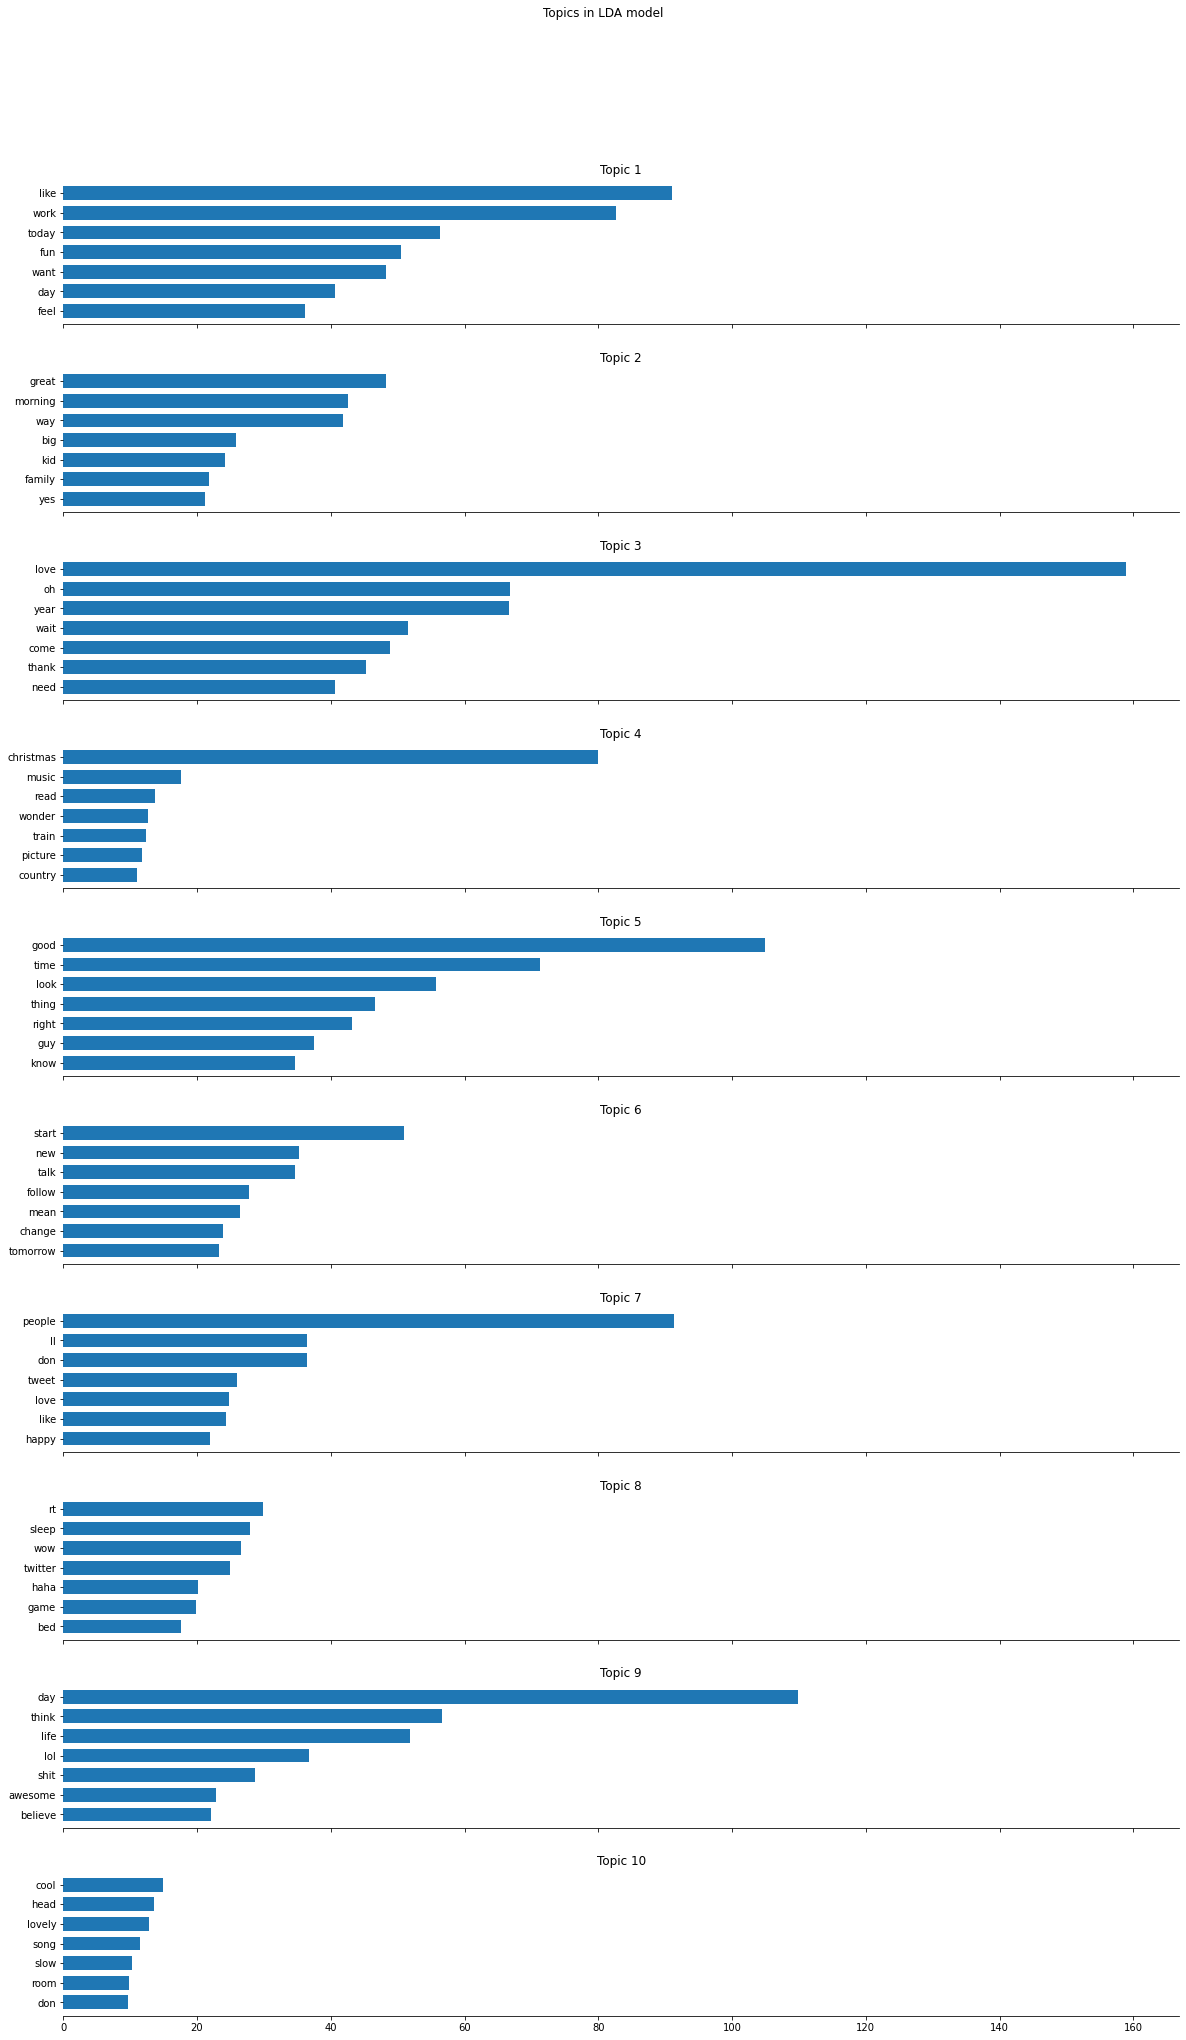

In [44]:
do_lda_and_plot(10, tweet_text_count_train)

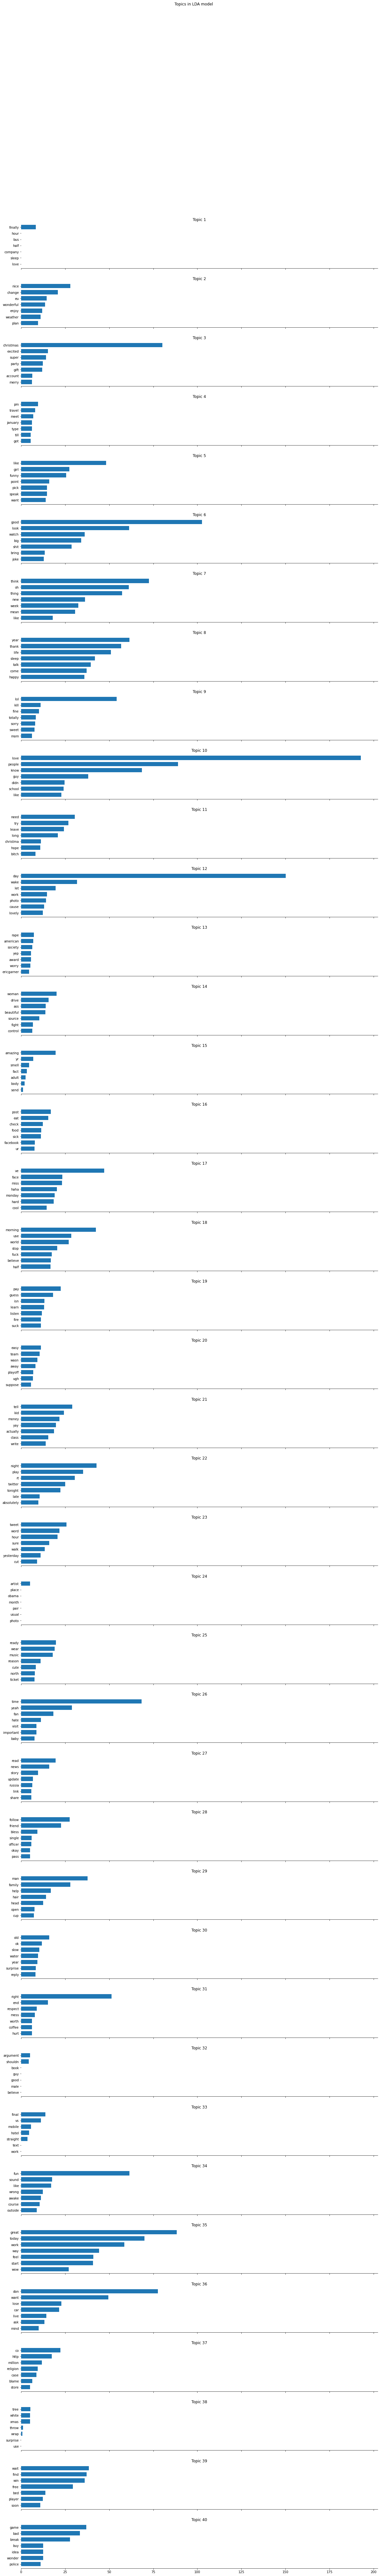

In [45]:
do_lda_and_plot(40, tweet_text_count_train)

## Embedding

In [46]:
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe

In [47]:
tweet_embedding_train = df_train[['clean_text', 'Label']]
tweet_embedding_validation = df_validation[['clean_text', 'Label']]

In [48]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)

In [49]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=5)

TWEET = Field('clean_text', pretokenize_hooks=[str.lower], numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(tweet_embedding_train, fields)
validation = TabularDataset.from_pandas(tweet_embedding_validation, fields)
train.finalize_fields()

glove = GloVe()
# Load only the vectors of vocab words.
embeddings = glove.load_vocab(vocab)

# Generate padded batch.
train_batch = train.batch(add_padding=True)
test_batch = validation.batch(add_padding=True)

In [50]:
train_batch['clean_text'].astype(int)

array([[ 70,   3, 178, ...,   1,   1,   1],
       [  7, 116,   0, ...,   1,   1,   1],
       [371, 630,   8, ...,   1,   1,   1],
       ...,
       [ 29, 732,   0, ...,   1,   1,   1],
       [548, 142,   9, ...,   1,   1,   1],
       [410,   0,   3, ...,   1,   1,   1]])

In [51]:
tweet_train = embeddings[train_batch['clean_text'].astype(int)]
tweet_test = embeddings[test_batch['clean_text'].astype(int)]
# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)
# Median
tweet_train_median = np.median(tweet_train, axis=1)
tweet_test_median = np.median(tweet_test, axis=1)
# Variance
tweet_train_std = tweet_train.std(axis=1)
tweet_test_std = tweet_test.std(axis=1)

In [52]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
tweet_embedding_train = pd.merge(tweet_embedding_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
tweet_embedding_test = pd.merge(tweet_embedding_validation, embeddings_test_mean_df, left_index=True, right_index=True)

In [53]:
tweet_embedding_test

,clean_text,Label,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,Sweet United Nations video. Just in time for C...,1,-0.159667,-0.217751,0.543646,0.001110,-0.416158,-0.455675,-0.602538,0.578029,...,0.325830,0.856783,-0.153599,-0.281771,-0.109867,-0.741865,1.012955,-0.354066,0.421300,0.444316
1,3 episodes left I'm dying over here,0,0.131801,-0.279999,0.563577,-0.023044,-0.522329,-0.492932,-0.360170,0.855699,...,0.412636,1.231096,-0.250711,-0.405368,0.156410,-0.749371,0.997639,-0.161369,0.637156,0.162697
2,I can't breathe! was chosen as the most notabl...,1,-0.295534,0.047689,0.285027,-0.009504,-0.088041,-0.152842,-0.761569,0.029938,...,0.017757,-0.178537,-0.023305,0.002138,-0.335652,-0.192536,0.584546,-0.476269,-0.129455,0.435104
3,Nothing makes me happier then getting on the h...,1,-0.099541,-0.116039,0.286510,-0.034786,-0.272938,-0.214570,-0.435251,0.290868,...,0.182061,0.367028,-0.157913,-0.107073,-0.106003,-0.428571,0.617607,-0.262952,0.226211,0.355581
4,4:30 an opening my first beer now gonna be a l...,0,-0.127668,-0.188345,0.418749,-0.010024,-0.417191,-0.409913,-0.488667,0.556632,...,0.321778,0.793789,-0.149039,-0.256110,-0.032670,-0.696005,0.949733,-0.310015,0.376709,0.378398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,I'm glad the DC Council has it's priorities in...,1,0.028611,-0.279160,0.557872,-0.012714,-0.441188,-0.553056,-0.529747,0.745352,...,0.414464,0.958918,-0.194534,-0.314423,0.005303,-0.736664,1.037766,-0.216785,0.517503,0.279060
1141,"Obama whisked away to hospital, diagnosed with...",1,-0.232226,-0.091553,0.389078,0.000519,-0.309645,-0.415417,-0.642563,0.359225,...,0.247604,0.446662,-0.080992,-0.184508,-0.188878,-0.553365,0.799195,-0.401194,0.168283,0.467036
1142,true n that's y we r jaded EVERY YEAR,0,-0.038899,-0.237817,0.557651,-0.031861,-0.531287,-0.435205,-0.370875,0.717886,...,0.436195,1.044070,-0.195505,-0.335987,0.092727,-0.761759,0.937091,-0.266890,0.501629,0.265438
1143,Thanks for shutting the city down..,1,-0.000414,-0.313178,0.629394,-0.044185,-0.543033,-0.493028,-0.461677,0.821429,...,0.430437,1.243434,-0.238828,-0.361811,0.036899,-0.883423,1.082173,-0.273439,0.623386,0.319134


In [54]:
from sklearn.linear_model import LogisticRegression
X_ = tweet_embedding_train[[x for x in range(300)]]
y_ = tweet_embedding_train['Label']
clf = LogisticRegression(solver='liblinear', C=4.16, penalty='l1').fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_test = tweet_embedding_test[[x for x in range(300)]]
y_test = tweet_embedding_test['Label']
print(clf.score(X_test, y_test))

Train score
0.625
Validation score
0.5851528384279476


In [55]:
## Features
## Broj neg rijeci
## Broj poz rijeci
## Omjer
## Udaljenost izmedu poz i neg rijeci

### KMeans using embeddings

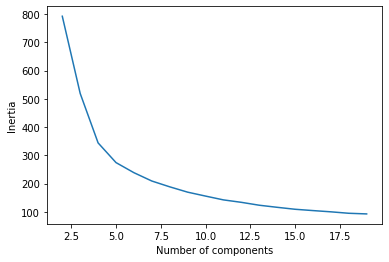

In [56]:
# 3 ili 5

inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(X_)
    inertia.append(model.inertia_)
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

Potrebno dodatno preprocesat da samo rjeci ostanu

In [57]:
import nltk
nltk.download('vader_lexicon') # if error run this

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [58]:
from nltk.sentiment import SentimentIntensityAnalyzer
import copy

def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['clean_text']) > 0:
            doc = nlp(row['clean_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(copy.copy(current_neg))
            neg_word_count.append(copy.copy(len(current_neg)))
            pos_words.append(copy.copy(current_pos))
            pos_word_count.append(copy.copy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [59]:
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text
3753,3771,1,Time to free ourselves of the Tyranny of the U...,123,22,0,0,0,22,0,0,Time to free ourselves of the Tyranny of the U...
1910,1914,0,is too complex a word for him to understand @...,79,9,3,0,0,12,0,0,is too complex a word for him to understand
3791,3809,1,@BBCRadMac @StuartMaconie years ago in M && S ...,134,22,2,1,0,25,1,0,years ago in M && S in Rochdale they had 2 lef...
3774,3792,1,China calls US hypocritical on #humanrights bu...,133,19,1,1,1,21,0,0,China calls US hypocritical on but Chinese pea...
2712,2716,0,"Coin ! erraji: "" ZeeGingaNinja: because it see...",135,17,0,1,1,18,1,0,"Coin ! erraji: "" ZeeGingaNinja: because it see..."
...,...,...,...,...,...,...,...,...,...,...,...,...
765,766,0,"@jerridsebesta my mom told me not to do it, bu...",56,11,1,0,0,12,0,0,"my mom told me not to do it, but I'm fine"
212,213,1,So Aaron sorkin goes on @todayshow to talk ab...,130,22,1,0,0,23,0,0,So Aaron sorkin goes on to talk about not liki...
737,738,1,@STN_Airport your busy staff standing about w...,91,9,1,1,1,11,0,0,your busy staff standing about when people que...
2052,2056,1,!!! RT @JeremyClarkson: Of all the places to g...,94,14,1,0,1,15,3,0,!!! RT Of all the places to get stuck in a tra...


In [60]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)

In [61]:
df_train['neg_word_count'] = neg_word_count_train
df_train['neg_word'] = neg_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['pos_word'] = pos_words_train
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text,neg_word_count,neg_word,pos_word_count,pos_word
3753,3771,1,Time to free ourselves of the Tyranny of the U...,123,22,0,0,0,22,0,0,Time to free ourselves of the Tyranny of the U...,0,[],3,"[free, tolerant, like]"
1910,1914,0,is too complex a word for him to understand @...,79,9,3,0,0,12,0,0,is too complex a word for him to understand,0,[],0,[]
3791,3809,1,@BBCRadMac @StuartMaconie years ago in M && S ...,134,22,2,1,0,25,1,0,years ago in M && S in Rochdale they had 2 lef...,0,[],0,[]
3774,3792,1,China calls US hypocritical on #humanrights bu...,133,19,1,1,1,21,0,0,China calls US hypocritical on but Chinese pea...,1,[hypocritical],2,"[peace, prize]"
2712,2716,0,"Coin ! erraji: "" ZeeGingaNinja: because it see...",135,17,0,1,1,18,1,0,"Coin ! erraji: "" ZeeGingaNinja: because it see...",0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,766,0,"@jerridsebesta my mom told me not to do it, bu...",56,11,1,0,0,12,0,0,"my mom told me not to do it, but I'm fine",0,[],1,[fine]
212,213,1,So Aaron sorkin goes on @todayshow to talk ab...,130,22,1,0,0,23,0,0,So Aaron sorkin goes on to talk about not liki...,1,[bitch],1,[like]
737,738,1,@STN_Airport your busy staff standing about w...,91,9,1,1,1,11,0,0,your busy staff standing about when people que...,0,[],0,[]
2052,2056,1,!!! RT @JeremyClarkson: Of all the places to g...,94,14,1,0,1,15,3,0,!!! RT Of all the places to get stuck in a tra...,0,[],0,[]


In [62]:
df_validation['neg_word_count'] = neg_word_count_val
df_validation['neg_word'] = neg_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['pos_word'] = pos_words_val

In [63]:
from sklearn.linear_model import LogisticRegression
X_ = df_train[['neg_word_count', 'pos_word_count']]
y_ = df_train['Label']
clf = LogisticRegression(random_state=0).fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[['neg_word_count', 'pos_word_count']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

Train score
0.5838323353293413
Validation score
0.5772925764192139


In [64]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        lol then
pos_word             [lol]
pos_word_count           1
neg_word                []
neg_word_count           0
Name: 1336, dtype: object

In [65]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(copy.copy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [66]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)

In [67]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_train

,Tweet index,Label,Tweet text,length,word_count,tag_count,hashtag_count,link_count,smiley_count,exclamation_mark_count,has_emoji,clean_text,neg_word_count,neg_word,pos_word_count,pos_word,pos_neg_within_5
3753,3771,1,Time to free ourselves of the Tyranny of the U...,123,22,0,0,0,22,0,0,Time to free ourselves of the Tyranny of the U...,0,[],3,"[free, tolerant, like]",0
1910,1914,0,is too complex a word for him to understand @...,79,9,3,0,0,12,0,0,is too complex a word for him to understand,0,[],0,[],0
3791,3809,1,@BBCRadMac @StuartMaconie years ago in M && S ...,134,22,2,1,0,25,1,0,years ago in M && S in Rochdale they had 2 lef...,0,[],0,[],0
3774,3792,1,China calls US hypocritical on #humanrights bu...,133,19,1,1,1,21,0,0,China calls US hypocritical on but Chinese pea...,1,[hypocritical],2,"[peace, prize]",1
2712,2716,0,"Coin ! erraji: "" ZeeGingaNinja: because it see...",135,17,0,1,1,18,1,0,"Coin ! erraji: "" ZeeGingaNinja: because it see...",0,[],0,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,766,0,"@jerridsebesta my mom told me not to do it, bu...",56,11,1,0,0,12,0,0,"my mom told me not to do it, but I'm fine",0,[],1,[fine],0
212,213,1,So Aaron sorkin goes on @todayshow to talk ab...,130,22,1,0,0,23,0,0,So Aaron sorkin goes on to talk about not liki...,1,[bitch],1,[like],0
737,738,1,@STN_Airport your busy staff standing about w...,91,9,1,1,1,11,0,0,your busy staff standing about when people que...,0,[],0,[],0
2052,2056,1,!!! RT @JeremyClarkson: Of all the places to g...,94,14,1,0,1,15,3,0,!!! RT Of all the places to get stuck in a tra...,0,[],0,[],0


In [68]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']
clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))
print('Validation score')
X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']
print(clf.score(X_val, y_val))

Train score
0.5134730538922155
Validation score
0.5048034934497817


In [ ]:
within_5_val

### Grid search

In [70]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': np.logspace(-4, 4, 20), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], }


X_ = df_train.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text', 'pos_word', 'neg_word'], axis=1)
y_ = df_train['Label']
clf = LogisticRegression()

model = GridSearchCV(clf, param_grid=params, cv=5)

model.fit(X_, y_)

print('Train score')
print(model.score(X_, y_))
print('Validation score')
X_val = df_validation.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text', 'pos_word', 'neg_word'], axis=1)
y_val = df_validation['Label']
print(model.score(X_val, y_val))

Train score
0.6283682634730539
Validation score
0.6235807860262009


In [71]:
from sklearn.tree import DecisionTreeClassifier

params = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' : ['gini', 'entropy', 'log_loss']
             }


X_ = df_train.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text', 'pos_word', 'neg_word'], axis=1)
y_ = df_train['Label']
clf = DecisionTreeClassifier()

model = GridSearchCV(clf, param_grid=params, cv=5)

model.fit(X_, y_)

print('Train score')
print(model.score(X_, y_))
print('Validation score')
X_val = df_validation.drop(['Tweet index', 'Label', 'Tweet text', 'clean_text', 'pos_word', 'neg_word'], axis=1)
y_val = df_validation['Label']
print(model.score(X_val, y_val))

Train score
0.6613023952095808
Validation score
0.634061135371179
